In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pyntcloud import PyntCloud
import plyfile as ply
import sys
import DracoPy
import shutil
import pandas as pd

# Compression of labeled Point Clouds

## Dataset: SELMA [1]

We consider SELMA [1], a dataset for semantic segmentation that contains more than 30K unique waypoints acquired from 24 different sensors including RGB, depth, seman- tic cameras and LiDARs.

### LIDARs
In particular, our analysis focuses on the LiDAR data, which are collected by means of 3 semantic LiDARs, each with 64 vertical channels, generating 100000 points per second, with a range of 100 meters. Point clouds are saved in PLY format.
LIDARS are placed on a vehicle as follows:

- *1 top LiDARs (TOP)*, with a 360° view of the scene.
- *2 front-lateral LiDARs* placed on the headlights with 270° of aperture, overlapping in the front of the ego vehicle. 


The positioning of the LiDARs is shown in the following figure:

<p align="center">
  <img src="references/sensors.png" width="700" />
</p>

### Scene
The dataset contains different scenes, in different weather conditions, nevetheless, we consider the following setup:
- Town: Town0, A basic town layout with ”T junctions” between roads.
- Condition: Clear Sunset


### Merging
We merge the point clouds from the 3 LiDARs, in order to have a single point cloud with all the three LiDARs information. 



In [ ]:
import open3d as o3d
from tqdm import tqdm

def combine (
    main_dir, 
    Nfiles=100,
    outdir='dataset_final',
    ):
    import glob 
    # find all scan codes
    left_lidar_codes = glob.glob(os.path.join(main_dir, 'LIDAR_FRONT_LEFT', '*.ply'))
    left_lidar_codes = [f.split('/')[-1].split('.')[0] for f in left_lidar_codes]
    left_lidar_codes.sort()
    print (f"Number of left lidar codes: {len(left_lidar_codes)}")

    right_lidar_codes = glob.glob(os.path.join(main_dir, 'LIDAR_FRONT_RIGHT', '*.ply'))
    right_lidar_codes = [f.split('/')[-1].split('.')[0] for f in right_lidar_codes]
    right_lidar_codes.sort()
    print (f"Number of left lidar codes: {len(left_lidar_codes)}")

    top_lidar_codes = glob.glob(os.path.join(main_dir, 'LIDAR_TOP', '*.ply'))
    top_lidar_codes = [f.split('/')[-1].split('.')[0] for f in top_lidar_codes]
    top_lidar_codes.sort()
    print (f"Number of left lidar codes: {len(left_lidar_codes)}")

    # find intersection of scan code
    print ("Finding intersection of scan codes")
    scan_codes = set(left_lidar_codes).intersection(set(right_lidar_codes)).intersection(set(top_lidar_codes))
    scan_codes = list(scan_codes)
    scan_codes.sort()
    scan_codes = scan_codes[:Nfiles]
    print (f"Number of scan codes: {len(scan_codes)}")


    # combine lidar data
    all_lidars = ['LIDAR_FRONT_LEFT', 'LIDAR_FRONT_RIGHT', 'LIDAR_TOP']
    outdir = os.path.join(main_dir, outdir)
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    # save combined point clouds and labels
    for code in tqdm(scan_codes):
        pcd_combined = o3d.geometry.PointCloud() 
        labels = []
        for lidar in all_lidars:
            file = os.path.join(main_dir, lidar,  code + '.ply')
            # load labels, i.e the  PlyProperty('ObjTag', 'uchar')), fourth property of the ply file
            plydata = ply.PlyData.read(file)
            labels += list(np.array(plydata.elements[0].data['ObjTag']))
            
            # load point clouds
            pc = o3d.io.read_point_cloud(file, format='ply')
            pcd_combined += pc

        

        # get labels
        labels = np.array(labels)
        #save labels
        # np.save(os.path.join(outdir, code + '_labels.npy'), labels)
        o3d.io.write_point_cloud(os.path.join(outdir, code + '.ply'), pcd_combined)

        # read again the file with plyfile and add the labels as a property
        plydata = ply.PlyData.read(os.path.join(outdir, code + '.ply'))

        # add the labels as a property
        x, y, z = plydata.elements[0].data['x'], plydata.elements[0].data['y'], plydata.elements[0].data['z']
        element = ply.PlyElement.describe(np.array(list(zip(x, y, z, labels)), dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('ObjTag', 'u1')]), 'vertex')
        plydata.elements = [element]
        plydata.write(os.path.join(outdir, code + '.ply'))
        

In [ ]:
#  create the final dataset 
main_dir = 'dataset-downloader-kit/CV/dataset/Town01_Opt_ClearSunset'
combine(main_dir, Nfiles=100, outdir='dataset_final')

### Label


Labelling is based on 36 classes, which are described in the following table:

| Class | Description |
| --- | --- |
| 0 | Unlabeled |
| 1 | Building |
| 2 | Fence |
| 3 | Other |
| 5 | Pole |
| 6 | Road Line |
| 7 | Road |
| 8 | Sidewalk |
| 9 | Vegetation |
| 10 | ego vehicle |
| 11 | wall |
| 12 | traffic sign |
| 13 | sky |
| 14 | ground |
| 15 | bridge |
| 16 | rail track |
| 17 | guard rail |
| 18 | traffic light |
| 19 | static |
| 20 | dynamic |
| 21 | water |
| 22 | terrain |
| 40 | person |
| 41 | rider |
| 100 | car |
| 101 | truck |
| 102 | bus |
| 103 | tram/train |
| 104 | motorcycle |
| 105 | unknown |

Let us now show the distribution of the classes in the part of the dataset we are considering.


In [3]:
main_dir = 'dataset-downloader-kit/CV/dataset/Town01_Opt_ClearSunset'

all_labels = []
for file in glob.glob(os.path.join(main_dir, 'dataset_final', '*.ply')):
    plydata = ply.PlyData.read(file)
    all_labels += list(np.array(plydata.elements[0].data['ObjTag']))

In [18]:
labels_df = pd.DataFrame(all_labels, columns=['labels'])
labels_df = labels_df['labels'].value_counts()
labels_df = labels_df.to_frame()

In [19]:
labels_df['counts'] = labels_df['labels']
labels_df['labels'] = labels_df.index
#reset index
labels_df = labels_df.reset_index(drop=True)

In [68]:
label_name_map = {
    0: 'Unlabeled', 
    1: 'Building',
    2: 'Fence',
    3: 'Other',
    5: 'Pole',
    6: 'Road Line',
    7: 'Road',
    8: 'Sidewalk',
    9: 'Vegetation',
    10: 'ego vehicle',
    11: 'wall',
    12: 'traffic sign',
    13: 'sky',
    14: 'ground',
    15: 'bridge',
    16: 'rail track',
    17: 'guard rail',
    18: 'traffic light',
    19: 'static',
    20: 'dynamic',
    21: 'water',
    22: 'terrain',
    40: 'person',
    41: 'rider',
    100: 'car',
    101: 'truck',
    102: 'bus',
    103: 'tram/train',
    104: 'motorcycle',
    105: 'unknown',
}

labels_df['labels_names'] = labels_df['labels'].map(label_name_map)
labels_df['percentage'] = labels_df['counts']*100/labels_df['counts'].sum()

In [69]:
labels_df

,labels,counts,labels_names,percentage
0,7,9740987,Road,37.157346
1,8,4616277,Sidewalk,17.608955
2,10,4500953,ego vehicle,17.169047
3,1,1511467,Building,5.765545
4,0,1332871,Unlabeled,5.084284
5,9,1210176,Vegetation,4.616260
6,100,1080937,car,4.123273
7,40,388419,person,1.481638
8,11,381680,wall,1.455932
9,2,367643,Fence,1.402387


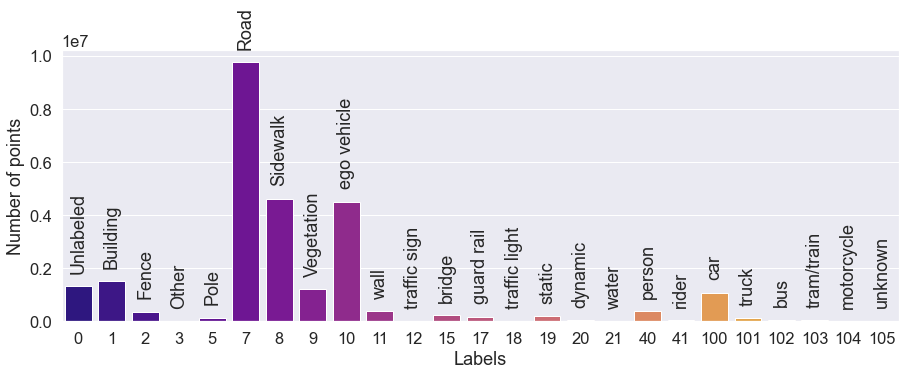

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", font_scale=1.5, palette="Dark2")

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='labels', y='counts', data=labels_df, ax=ax, palette="plasma")
ax.set_xlabel('Labels')
ax.set_ylabel('Number of points')

xticks = ax.get_xticklabels()
# add name as vertical text to the bars
for xx in xticks:
    xindex = int(xx.get_text())
    xvalue = xx.get_position()[0]
    label_name = label_name_map [xindex]
    try:
        label_count = labels_df[labels_df['labels'] == xindex]['counts'].to_numpy()[0] + 0.05e7
    except:
        label_count = 0

    ax.text(xvalue, label_count, label_name, rotation=90, va='bottom', ha='center', fontsize=18)

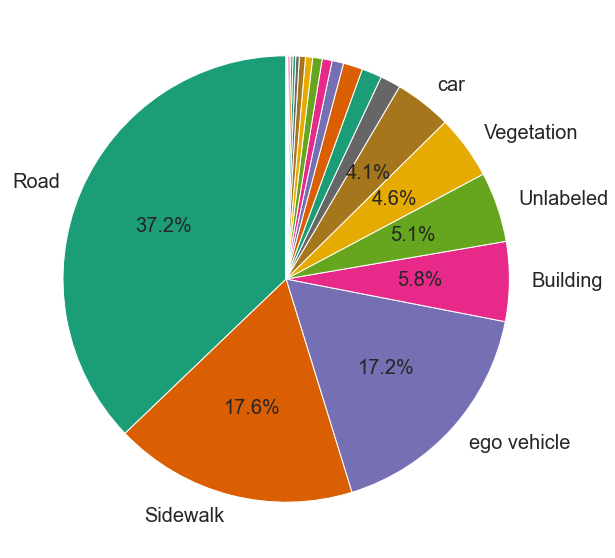

In [98]:
# pie chart
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# dont show the labels for the small slices in percentage
autopct=lambda pct: '{:1.1f}%'.format(pct) if pct > 3 else ''
wedges, texts, autotexts =  ax.pie(labels_df['percentage'], labels=labels_df['labels_names'],
                    autopct=autopct, startangle=90, textprops={'fontsize': 20})
# dont show the labels for the small slices in percentage
for at, t in zip(autotexts, texts):
    if at.get_text() == '':
        t.set_text('')

### Point cloud visualization


[1] _SELMA: SEmantic Large-scale Multimodal Acquisitions in Variable Weather, Daytime and Viewpoints_, Testolina, Paolo and Barbato, Francesco and U. Michieli, M. Giordani and P. Zanuttigh and M. Zorzi, 2022